In [100]:
import scipy.optimize

import Modules.SQcircuit_extensions as sq_ext
import Modules.perturbation_theory as pt
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload 
import scipy as sp
from scipy.optimize import curve_fit, minimize

# %matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
reload(sq_ext)
reload(sq)
reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

<Figure size 640x480 with 0 Axes>

In [101]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0  = h/(2*e0)

## Q - Cavity 2xN effective Hamiltonian - vs $\varphi_{ext}$

### Qutrit

In [102]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_3', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
# C_F_eff *=0.8
# C_R_eff*=0.8
# L_C_eff = 1e100 

In [103]:
n_eig  = 8

nmax_f=15
nmax_r=10

Nr=4

basis_states = []
N = 2
for q in [0,1,2]:
    for n in range(N):
        basis_states.append((q, n))

N_elements = 2
max_excitations_mediating_states = 2
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)

labels_low = [f'({i},{j})' for i, j in basis_states]
labels_low
# labels_high = [f'({i},{j})' for i, j in mediating_states]

['(0,0)', '(0,1)', '(1,0)', '(1,1)', '(2,0)', '(2,1)']

In [104]:
reload(sq_ext)

n_plot = 200
φ_ext_values = np.linspace(0.5, 0.65, n_plot)

fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5,nmax_f=nmax_f)
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ,nmax_r=nmax_r)
Hf = fluxonium_0.hamiltonian()
Hr = resonator.hamiltonian()
H_0_list =[Hf,Hr]

H_0, E_0, ψ_0_basis, ψ_0_mediating = sq_ext.ψ_0_from_H_0(H_0_list, basis_states, mediating_states, n_eig)
E_0_ψ_0_basis = [np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0, 0]) / 2 / np.pi / GHz for ψ_0_i in ψ_0_basis]
subspace_indices = sq_ext.find_close_indices_unique(E_0_ψ_0_basis, E_0)

print(subspace_indices)

[0, 2, 1, 4, 3, 7]


In [105]:
E_vs_φ_ext = np.zeros([len(φ_ext_values), len(basis_states)]) 
E_full_vs_φ_ext = np.zeros([len(φ_ext_values), n_eig]) 
H_eff_SWT_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states),len(basis_states)], dtype='complex')
H_eff_p1_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states),len(basis_states)], dtype='complex')
H_eff_SWT_decomp_vs_φ_ext = np.zeros([len(φ_ext_values),9, 4], dtype='complex')
for i, φ_ext in enumerate(φ_ext_values):
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
    H = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff )
    
    E, ψ = sq_ext.diag(H, n_eig, out='GHz', solver='Qutip', qObj=True, remove_ground=True)
    E_basis = E[subspace_indices]
    ψ_basis = ψ[subspace_indices]
    
    E_full_vs_φ_ext[i] = E
    E_vs_φ_ext[i] = np.sort(E_basis)
    
    H_eff_SWT_vs_φ_ext[i] = sq_ext.H_eff_SWT_large(ψ_0_basis, ψ_basis, E_basis )
    H_eff_p1_vs_φ_ext[i] = sq_ext.H_eff_p1_large(ψ_0_basis, H, out='GHz', real=True, remove_ground=False)
    
    # H_eff_SWT_decomp_vs_φ_ext[i] = sq_ext.decomposition_in_pauli_3xN_qutrit_resonator(H_eff_SWT_vs_φ_ext[i], print_pretty=False)

In [134]:
reload(sq_ext)

H0_f  = fluxonium_0.hamiltonian()
E0_f, ψ0_f = sq_ext.diag(H0_f, 3, solver='numpy', qObj=True, remove_ground=True)

ωq_01 = E0_f[1]
ωq_02 = E0_f[2]
gΦ_λ1, gΦ_λ6 = sq_ext.get_parameters_qutrit_cavity(fluxonium, resonator, L_C_eff)

ωq_01_opt, ωq_02_opt, ω_r_opt, gΦ_λ1_opt, gΦ_λ6_opt = res.x

ω_r = sq_ext.diag(Hr,2, remove_ground=True)[0][1]
ω_r = sq_ext.diag(resonator.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]


E_uc_qutrit_cavity_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states)])
E_uc_qutrit_cavity_vs_φ_ext_opt = np.zeros([len(φ_ext_values),len(basis_states)])
g_λ_vs_φ_ext = np.zeros([len(φ_ext_values), 9])
gx_SWT_vs_φ_ext= np.zeros(len(φ_ext_values) )
gz_SWT_vs_φ_ext= np.zeros(len(φ_ext_values) )

for i, φ_ext in enumerate(φ_ext_values):
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
    H = fluxonium.hamiltonian()
    
    g_SWT = sq_ext.decomposition_in_pauli_2x2(sq_ext.H_eff_SWT(fluxonium_0.hamiltonian(),fluxonium.hamiltonian(),2))
    gx_SWT_vs_φ_ext[i] = g_SWT[1]
    gz_SWT_vs_φ_ext[i] = g_SWT[-1]-ωq_01/2
    
    E_f_vs_φ_ext, ψ_f = sq_ext.diag(H, 3, solver='numpy', qObj=True, remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ0_f, ψ_f, E_f_vs_φ_ext, remove_I=True)
    H_eff_SWT_decomp_f = sq_ext.decomposition_in_pauli_3x3(H_eff_SWT, print_pretty=False)
    
    g_λ = H_eff_SWT_decomp_f
    g_λ_vs_φ_ext[i] = g_λ
    g_λ1, g_λ3, g_λ4, g_λ6, g_λ8 =[g_λ[1], g_λ[3]+ωq_01/2, g_λ[4], g_λ[6], g_λ[8]-(ωq_01 - 2 * ωq_02) / 2 / np.sqrt(3) ]
    
    H_uc_qutrit_cavity = sq_ext.hamiltonian_uc_qutrit_cavity(ωq_01, ωq_02, g_λ1, g_λ3, g_λ4, g_λ6, g_λ8, ω_r, gΦ_λ1, gΦ_λ6, N = Nr)
    E_uc_qutrit_cavity_vs_φ_ext[i] = sq_ext.diag(H_uc_qutrit_cavity,n_eig=len(basis_states), out=None, solver='numpy', remove_ground=True)[0]
    
    g_λ1_opt, g_λ3_opt, g_λ4_opt, g_λ6_opt, g_λ8_opt =[g_λ[1], g_λ[3]+ωq_01_opt/2, g_λ[4], g_λ[6], g_λ[8]-(ωq_01_opt - 2 * ωq_02_opt) / 2 / np.sqrt(3) ]
    
    H_uc_qutrit_cavity_opt = sq_ext.hamiltonian_uc_qutrit_cavity(ωq_01_opt, ωq_02_opt, g_λ1_opt, g_λ3_opt, g_λ4_opt, g_λ6_opt
                                                             , g_λ8_opt, ω_r_opt, gΦ_λ1_opt, gΦ_λ6_opt, N = Nr)
    E_uc_qutrit_cavity_vs_φ_ext_opt[i] = sq_ext.diag(H_uc_qutrit_cavity_opt,n_eig=len(basis_states), out=None, solver='numpy', remove_ground=True)[0]

C:\Users\gabri\AppData\Local\Temp\ipykernel_14720\1657931840.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  g_λ_vs_φ_ext[i] = g_λ


In [132]:
def fit_global_qutrit_vs_φext(opt_vars, g_λ_vs_φ_ext, E_exact_vs_φ_ext, print_progress=True):
    ωq_01, ωq_02, ω_r, gΦ_λ1, gΦ_λ6  = opt_vars
    
    error_vs_φ_ext = np.zeros(len(E_exact_vs_φ_ext))
    
    for i, (g_λ, E_exact) in enumerate(zip(g_λ_vs_φ_ext, E_exact_vs_φ_ext)):
        g_λ1, g_λ3, g_λ4, g_λ6, g_λ8 =[g_λ[1], g_λ[3]+ωq_01/2, g_λ[4], g_λ[6], g_λ[8]-(ωq_01 - 2 * ωq_02) / 2 / np.sqrt(3) ]

        H_uc_qutrit_cavity = sq_ext.hamiltonian_uc_qutrit_cavity(ωq_01, ωq_02, g_λ1, g_λ3, g_λ4, g_λ6, g_λ8, ω_r, gΦ_λ1, gΦ_λ6, N = Nr)
        E_uc_qutrit_cavity_vs_φ_ext[i] = sq_ext.diag(H_uc_qutrit_cavity,n_eig=len(basis_states), out=None, solver='numpy', remove_ground=True)[0]
        
        error_vs_φ_ext[i] = np.mean(np.abs(E_uc_qutrit_cavity_vs_φ_ext[i,:6] - E_exact[:6]))
        # error_vs_φ_ext[i] = np.mean(np.abs(E_uc_qutrit_cavity_vs_φ_ext[i,:3] - E_exact[:3]))

    if print_progress:
        print(f'The total error for {opt_vars} is {np.mean(error_vs_φ_ext)}')
        
    return np.mean(error_vs_φ_ext)


In [133]:
res = minimize(fit_global_qutrit_vs_φext, x0=[ωq_01, ωq_02, ω_r, gΦ_λ1, gΦ_λ6],
               args=(g_λ_vs_φ_ext, E_full_vs_φ_ext, True))
res.x

The total error for [3.071508612420 7.252610904993 5.220000000000 0.131129443508 0.195264255877] is 0.013385683998053248
The total error for [3.071508627321 7.252610904993 5.220000000000 0.131129443508 0.195264255877] is 0.013385683998053248
The total error for [3.071508612420 7.252610919894 5.220000000000 0.131129443508 0.195264255877] is 0.013385683998053248
The total error for [3.071508612420 7.252610904993 5.220000014901 0.131129443508 0.195264255877] is 0.013385681065376475
The total error for [3.071508612420 7.252610904993 5.220000000000 0.131129458410 0.195264255877] is 0.013385681205653768
The total error for [3.071508612420 7.252610904993 5.220000000000 0.131129443508 0.195264270778] is 0.013385682766495242
The total error for [3.071508612420 7.252610904993 5.416808606735 0.318524200449 0.277912714651] is 0.1401472954516038
The total error for [3.071508627321 7.252610904993 5.416808606735 0.318524200449 0.277912714651] is 0.1401472954516038
The total error for [3.071508612420 

array([3.071508612420, 7.252610904993, 5.221631030756, 0.169169616358, 0.239042917208])

### Qubit

In [98]:
ω_q = sq_ext.diag(fluxonium_0.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
ω_r = sq_ext.diag(resonator.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
g_Φ = sq_ext.get_parameters_QR(fluxonium_0,resonator,L_C_eff)
    
E_SWT_vs_φ_ext_qubit = np.zeros([len(φ_ext_values),4])

for i, (gx, gz) in enumerate(zip(gx_SWT_vs_φ_ext, gz_SWT_vs_φ_ext)):
    
    H= sq_ext.hamiltonian_uc_qubit_cavity(ω_q, gx, gz, ω_r, g_Φ, N=Nr)
    E_SWT_vs_φ_ext_qubit[i] = sq_ext.diag(H, 4, out=None, remove_ground=True)[0]


### Comparison qubit qutrit models

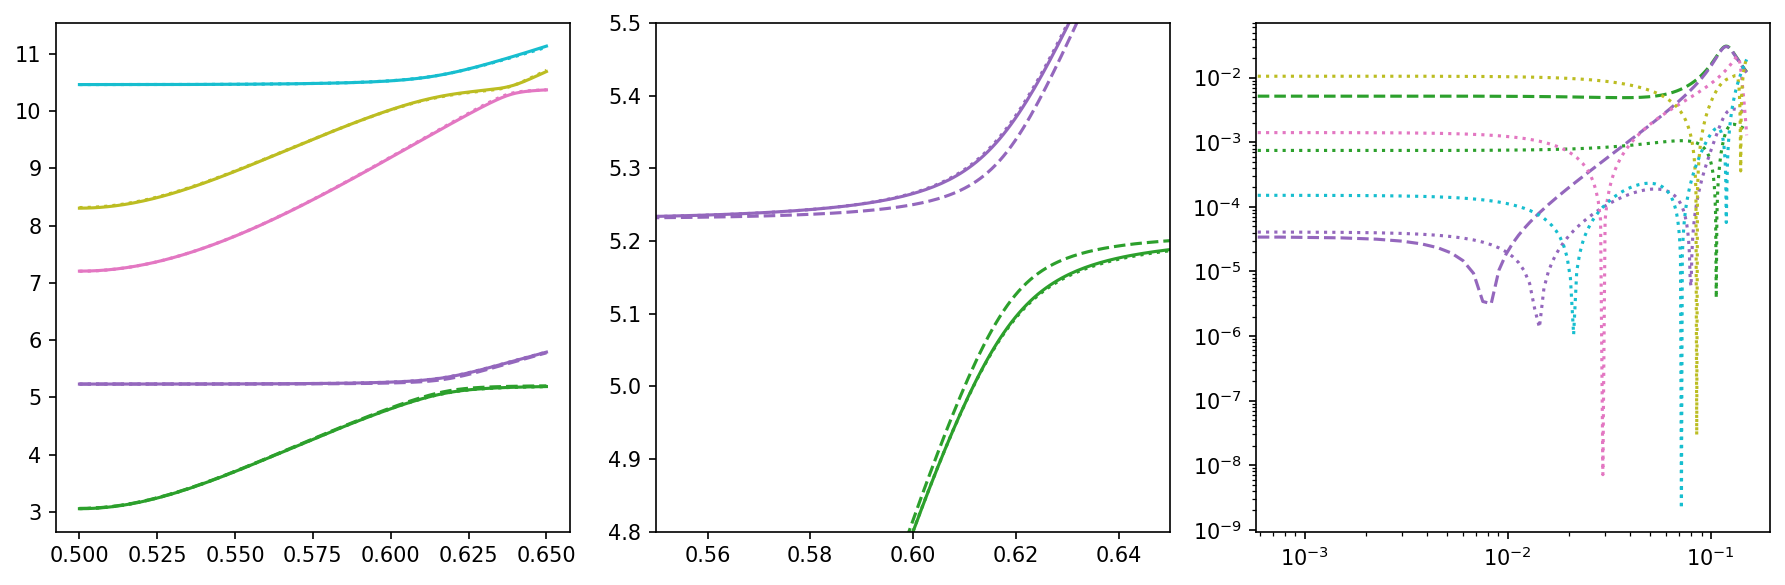

In [136]:
colors = figs.generate_colors_from_colormap(len(basis_states),'tab10')

fig, (ax1, ax1_zoom, ax2) = plt.subplots(ncols=3, figsize=[12,4],dpi=150)

for i in range(1, len(basis_states)):
    ax1.plot(φ_ext_values, E_full_vs_φ_ext[:,i], color= colors[i])
    # ax1.plot(φ_ext_values, E_uc_qutrit_cavity_vs_φ_ext[:,i], ':', color= colors[i])
    ax1.plot(φ_ext_values, E_uc_qutrit_cavity_vs_φ_ext_opt[:,i], ':', color= colors[i])
    
    ax1_zoom.plot(φ_ext_values, E_full_vs_φ_ext[:,i], color= colors[i])
    # ax1_zoom.plot(φ_ext_values, E_uc_qutrit_cavity_vs_φ_ext[:,i], ':', color= colors[i])
    ax1_zoom.plot(φ_ext_values, E_uc_qutrit_cavity_vs_φ_ext_opt[:,i], ':', color= colors[i])
    
    if i <=2:
        ax1.plot(φ_ext_values, E_SWT_vs_φ_ext_qubit[:,i], '--', color= colors[i])
        ax1_zoom.plot(φ_ext_values, E_SWT_vs_φ_ext_qubit[:,i], '--', color= colors[i])

# for i in range(1, 3):    
for i in range(1, 6):    
    # ax2.plot(φ_ext_values-0.5, np.abs(E_full_vs_φ_ext[:,i]-E_uc_qutrit_cavity_vs_φ_ext[:,i]), ':', color= colors[i])
    ax2.plot(φ_ext_values-0.5, np.abs(E_full_vs_φ_ext[:,i]-E_uc_qutrit_cavity_vs_φ_ext_opt[:,i]), ':', color= colors[i])
    if i <=2:
        ax2.plot(φ_ext_values-0.5, np.abs(E_vs_φ_ext[:,i]-E_SWT_vs_φ_ext_qubit[:,i]), '--', color= colors[i])

ax1_zoom.set_ylim([4.8, 5.5])
ax1_zoom.set_xlim([0.55,0.65])
    
ax2.set_yscale('log')
ax2.set_xscale('log')
fig.tight_layout()

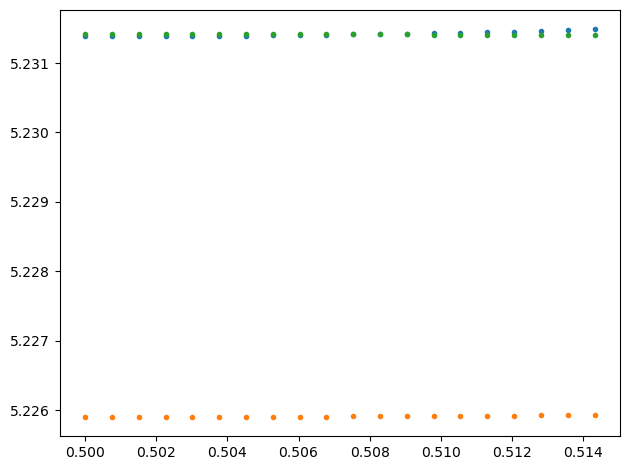

In [96]:
nx=20
fig, ax = plt.subplots()

ax.plot(φ_ext_values[:nx],E_full_vs_φ_ext[:nx,2],'.')
ax.plot(φ_ext_values[:nx],E_uc_qutrit_cavity_vs_φ_ext[:nx,2],'.')
ax.plot(φ_ext_values[:nx],E_SWT_vs_φ_ext_qubit[:nx,2],'.')
# ax.set_xlim(0.5,0.515)

fig.tight_layout()